In [254]:
%matplotlib notebook
import pandas as pd
import numpy as np
import math
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
from mlxtend.plotting import plot_confusion_matrix
import warnings
from scipy.signal import savgol_filter, find_peaks, correlate
from sklearn.decomposition import PCA
import scipy.fftpack as FFT
from sklearn.utils import shuffle
import joblib
import scipy.stats as stats
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [12,5]

In [255]:
def sampling_freq(df):
    start = df['time'].iloc[0]
    sum_samples = 0
    index = 0
    while  (start + pd.to_timedelta(1, unit='s')) < df['time'].iloc[-1]:
        end =  start + pd.to_timedelta(1, unit='s')
        sum_samples += df[(df['time'] >= start) & (df['time'] < end)].shape[0]
        start += pd.to_timedelta(1, unit='s')
        index += 1
    return sum_samples/index

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def convert_to_datetime(x):
    dt = datetime.fromtimestamp(x // 1000000000)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(x % 1000000000)).zfill(9)
    return s

def heatmap(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

    plt.show()
    
def preprocess(data, activity, drop_interval_begin = 3, drop_interval_end = 3):
    #convert nanoseconds to date 
    data['time'] = data['time'].apply(convert_to_datetime) 
    data['time'] = pd.to_datetime(data['time'])

#convert to same data type
    for i in range(1, 4): 
        data[column_names_org[i]] = data[column_names_org[i]].apply(convert_to_float)
    
#drop rows with NaN values 
    data.dropna(axis=0, how='any', inplace=True) #TODO: invullen met mean, mod of median / interpolatie

#drop duplicates 
    data.drop_duplicates(subset=None, keep='first', inplace = True)
    
    #drop first and last 3 sec
    indexFirst = data[ (data['time'].iloc[0]+ pd.to_timedelta(drop_interval_begin, unit='s')) > data['time'] ].index
    data.drop(indexFirst , inplace=True)
    indexLast = data[ (data['time'].iloc[-1]- pd.to_timedelta(drop_interval_end, unit='s')) < data['time'] ].index
    data.drop(indexLast , inplace=True)
    
    #add activity label
    data['activity'] = activity
    
    return data

#TODO: verschillende activiteiten in 1 frame
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
       
        # Retrieve the most often used label in this segment
        label = stats.mode(df['activity'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

   #print("ORG:",frames)
    # Bring the segments into a better shape
    frames = np.asarray(frames)#.reshape(-1, frame_size, N_FEATURES)
    print("NEW:",frames)
    labels = np.asarray(labels)

    return frames, labels

def windows(data, size, overlap):
    start = 0
    while start < data.count():
        yield start, start + size
        if(overlap):
            start += (size * overlap)
        else:
            start += size 
        
def segment_signal(data,window_size, overlap):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data["time"], window_size, overlap):
        start = int(start)
        end = int(end)
        x = data["x"][start:end]
        y = data["y"][start:end]
        z = data["z"][start:end]
        if(len(data["time"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

In [256]:
column_names_org = ['time', 'x', 'y', 'z']
moves = ["jump_fast", "jump_slow", "side_swing", "cross_over", "forward_180", "backward_180", "mistakes"]
freq = {}

freq["jump_fast"] = 55.55724863047715
freq["jump_slow"] = 51.69966253926424
freq["side_swing"] = 49.317387522335395
freq["cross_over"] = 51.93077692731317
freq["forward_180"] = 52.602864583333336
freq["backward_180"] = 53.0625

In [257]:
f = 0
for fq in freq.values():
    f += fq
f = f/len(freq)
f

52.361740033787214

## validation data

In [258]:
validation_data = pd.DataFrame()

In [259]:
# 6 jump_fast/jump_slow ???
validation_data2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\validation_data\scenario1_tim2.csv", sep=';', header=0, skipinitialspace=True)

#niet juist?
validation_data3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\validation_data\scenario2_tim.csv", sep=';', header=0, skipinitialspace=True)

validation_data4 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\validation_data\scenario3_elise.csv", sep=';', header=0, skipinitialspace=True)

<IPython.core.display.Javascript object>


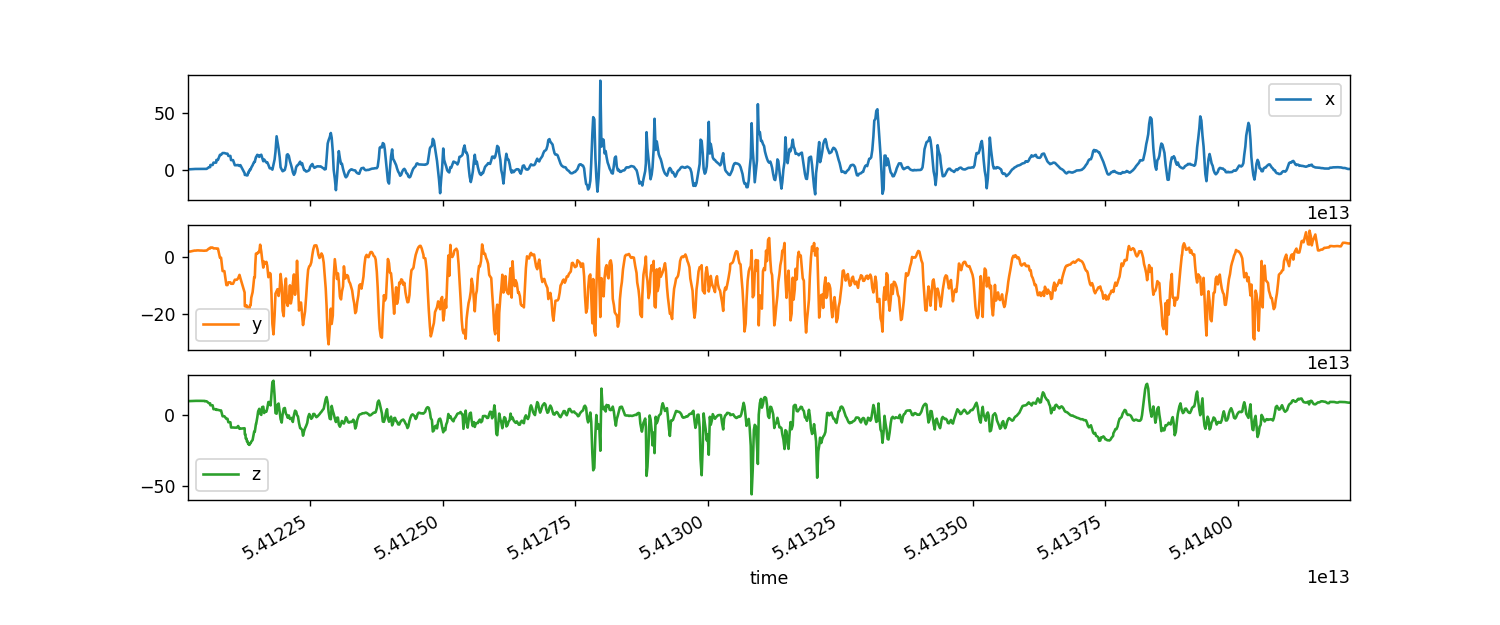

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002D105332888>,
      dtype=object)

In [260]:
validation_data2.plot(x='time', subplots=True)

<IPython.core.display.Javascript object>


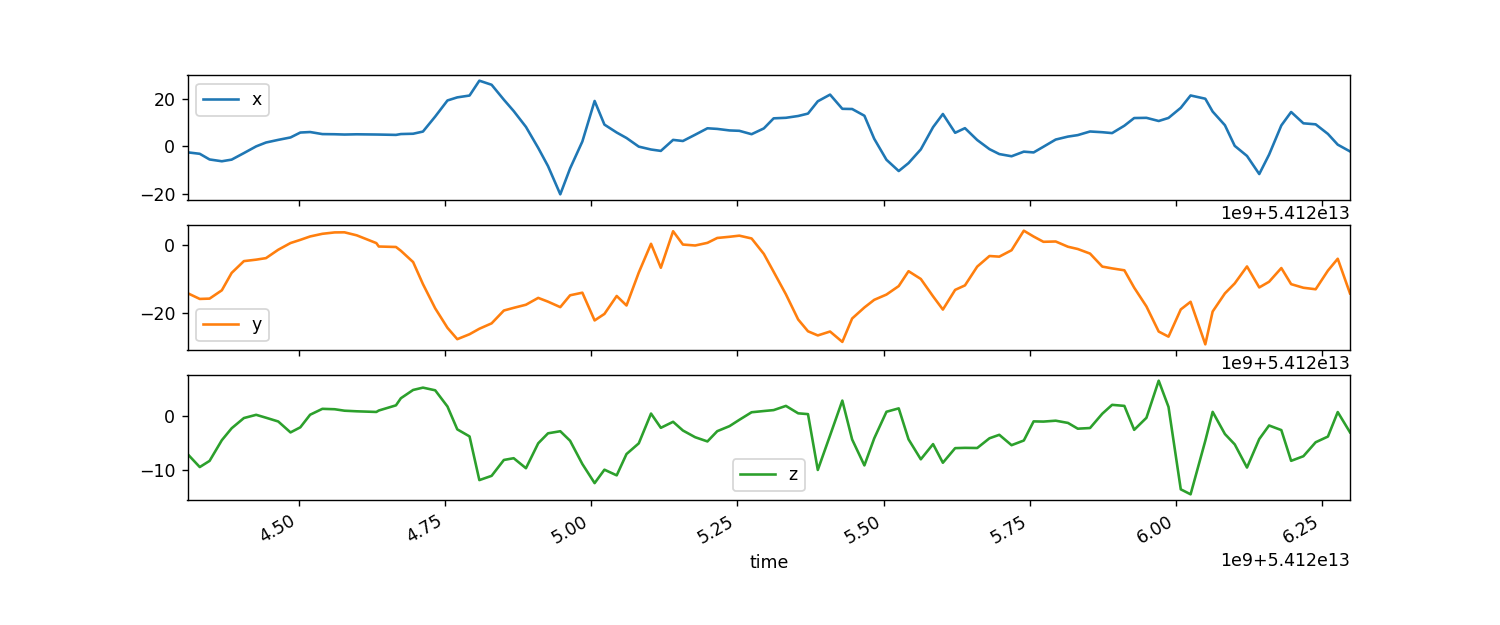

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002D104FFC788>,
      dtype=object)

In [261]:
f1 = validation_data2[ (validation_data2["time"] > 54124300000000) & (validation_data2["time"] < 54126300000000) ]
f1.plot(x='time', subplots=True)

In [262]:
val_data1 = pd.DataFrame()

In [263]:
val_data1 = val_data1.append(preprocess(validation_data2[(validation_data2["time"] > 54121300000000) & (validation_data2["time"] < 54124300000000) ],"jump_slow",0, 0))

val_data1= val_data1.append(preprocess(validation_data2[ (validation_data2["time"] > 54124300000000) & (validation_data2["time"] < 54126300000000) ], "jump_fast", 0, 0))

#val_data1= val_data1.append(preprocess(validation_data2[(validation_data2["time"] > 54126300000000) & (validation_data2["time"] < 54127700000000) ], "forward_180", 0, 0))

val_data1= val_data1.append(preprocess(validation_data2[ (validation_data2["time"] > 54127700000000) & (validation_data2["time"] < 54130600000000) ], "jump_slow", 0, 0))

val_data1= val_data1.append(preprocess(validation_data2[(validation_data2["time"] > 54130600000000) & (validation_data2["time"] < 54132800000000) ], "jump_fast", 0, 0))

val_data1= val_data1.append(preprocess(validation_data2[(validation_data2["time"] > 54132800000000) & (validation_data2["time"] < 54135600000000) ], "jump_slow", 0, 0))

#val_data1= val_data1.append(preprocess(validation_data2[(validation_data2["time"] > 54135600000000) & (validation_data2["time"] < 54137500000000) ], "backward_180", 0, 0))

val_data1= val_data1.append(preprocess(validation_data2[ (validation_data2["time"] > 54137500000000) ], "jump_slow", 0, 1.5))


In [264]:
#val_data1 = val_data1.append(preprocess(validation_data3[(validation_data3["time"] >= 54260100000000) & (validation_data3["time"] < 54261300000000) ],"mistake",0, 0))

In [265]:
val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54437200000000) & (validation_data4["time"] < 54439000000000) ],"jump_fast",0, 0))
val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54439000000000) & (validation_data4["time"] < 54440800000000) ],"side_swing",0, 0))
val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54440800000000) & (validation_data4["time"] < 54443600000000) ],"jump_slow",0, 0))
val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54443600000000) & (validation_data4["time"] < 54445000000000) ],"cross_over",0, 0))
val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54445000000000) & (validation_data4["time"] < 54447700000000) ],"jump_slow",0, 0))
#val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54447700000000) & (validation_data4["time"] < 54449700000000) ],"forward_180",0, 0))
val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54449700000000) & (validation_data4["time"] < 54451500000000) ],"jump_fast",0, 0))


## read datasets

In [266]:
jump_slow = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\notebooks\jump_slow_raw.csv", sep=';', header=0, skipinitialspace=True)
jump_fast = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\notebooks\jump_fast_raw.csv", sep=';', header=0, skipinitialspace=True)
side_swing = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\notebooks\side_swing_raw.csv", sep=';', header=0, skipinitialspace=True)
cross_over = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\notebooks\cross_over_raw.csv", sep=';', header=0, skipinitialspace=True)
#forward_180 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\notebooks\forward_180_zonder_pauze_raw.csv", sep=';', header=0, skipinitialspace=True)
#backward_180 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\notebooks\backward_180_zonder_pauze_raw.csv", sep=';', header=0, skipinitialspace=True)
#mistakes = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\mistakes_raw.csv", sep=';', header=0, skipinitialspace=True)

## merge all activities

In [267]:
#zonder mistakes
shape = np.min([
    jump_slow.shape[0],
    jump_fast.shape[0],
    side_swing.shape[0],
    cross_over.shape[0],
    #forward_180.shape[0],
    #backward_180.shape[0]
])

In [268]:
merged = pd.concat([
    jump_slow.head(shape),
    jump_fast.head(shape),
    side_swing.head(shape),
    cross_over.head(shape),
    #forward_180.head(shape),
    #backward_180.head(shape)
    
    #shuffle(mistakes).head(shape),
], ignore_index=True)
merged = merged.drop('Unnamed: 0', axis=1)
merged.shape

(60352, 7)

In [269]:
target = merged['activity']
merged

time         x          y          z  \
0      1970-01-02 00:59:35.097434112  1.648655   0.311067  -0.416351   
1      1970-01-02 00:59:35.114211328  1.959722  -0.392423  -1.488336   
2      1970-01-02 00:59:35.122599936  1.959722  -0.392423  -1.488336   
3      1970-01-02 00:59:35.130988544  1.959722  -0.392423  -1.488336   
4      1970-01-02 00:59:35.139377152  2.402394  -2.122434  -2.562713   
...                              ...       ...        ...        ...   
60347  1970-01-01 18:26:19.444690944  2.242075   1.708475   3.381058   
60348  1970-01-01 18:26:19.465662464 -7.542177  -4.967500  10.102497   
60349  1970-01-01 18:26:19.482439680 -3.476771  -8.355737   4.448257   
60350  1970-01-01 18:26:19.503411200 -0.866202  -6.082555   3.144169   
60351  1970-01-01 18:26:19.524382720 -0.990629 -12.701102   5.022535   

         activity            type  proefpersoon  
0       jump_slow  left_backwards             1  
1       jump_slow  left_backwards             1  
2       jump_slow  left_backwards             1  
3       jump_slow  left_backwards             1  
4       jump_slow  left_backwards             1  
...           ...             ...           ...  
60347  cross_over  left_backwards             2  
60348  cross_over  left_backwards             2  
60349  cross_over  left_backwards             2  
60350  cross_over  left_backwards             2  
60351  cross_over  left_backwards             2  

[60352 rows x 7 columns]

## labeling

In [270]:
#label activity
le = preprocessing.LabelEncoder()
le.fit(merged['activity'])

merged['activity'] = le.transform(merged['activity'])
val_data1['activity'] = le.transform(val_data1['activity'])

label = le.inverse_transform([0,1,2,3])
label

array(['cross_over', 'jump_fast', 'jump_slow', 'side_swing'], dtype=object)

## normalize

In [271]:
Normalizer = preprocessing.Normalizer().fit(merged[['x', 'y', 'z']])

merged[['x', 'y', 'z']] = Normalizer.transform(merged[['x', 'y', 'z']])
val_data1[['x', 'y', 'z']] = Normalizer.transform(val_data1[['x', 'y', 'z']])

merged.activity.unique()

array([2, 1, 3, 0], dtype=int64)

## segmentation

per activiteit zodat in 1 segment zeker 1 bepaalde activiteit voorkomt. TODO: nog geen rekening gehouden met verwijderen van trantities bij 180s

In [272]:
segments_list = []
labels_list =  []
for m in merged.activity.unique():
    df = merged[merged["activity"] == m]
    
    for t in df.type.unique():
        df2 = df[df["type"] == t]
        
        for p in df2.proefpersoon.unique():
            segments, labels = segment_signal(df2[df2["proefpersoon"] == p], int(f*2), 0.3)
            segments_list.append(segments)
            labels_list.append(labels)
            
segments = np.concatenate(segments_list)
labels = np.concatenate(labels_list)

print(labels.shape)
print(segments.shape)

(1882,)
(1882, 104, 3)


In [273]:
val_data, val_labels = segment_signal(val_data1, int(f*2), 1)

#### 2D model

In [274]:
#segments = segments.reshape(len(segments),len(segments[0]), len(segments[0][0]), 1 )

In [275]:
segments.shape, labels.shape

((1882, 104, 3), (1882,))

## neural network

https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

In [276]:
X = segments
Y = labels
X.shape, Y.shape

((1882, 104, 3), (1882,))

In [277]:
X_train, X_test, y_train, y_test_1 = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)
X_train.shape, y_test_1.shape

((1505, 104, 3), (377,))

In [278]:
y_train = np.asarray(pd.get_dummies(y_train), dtype = np.int8)
y_test = np.asarray(pd.get_dummies(y_test_1), dtype = np.int8)
y_val = np.asarray(pd.get_dummies(val_labels), dtype = np.int8)
Y_dummies = np.asarray(pd.get_dummies(Y), dtype = np.int8)

y_train.shape, y_test.shape

((1505, 4), (377, 4))

In [279]:
X_train = X
y_train = Y_dummies

y_labels = val_labels
X_test = val_data
y_test = y_val

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1882, 104, 3)
(1882, 4)
(14, 104, 3)
(14, 4)


In [280]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras import regularizers

In [281]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
n_outputs

4

In [282]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
#model.add(Dense(64, input_dim=3,kernel_regularizer=regularizers.l2(0.1), activity_regularizer=regularizers.l1(0.1)))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [283]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [284]:
epo = 50
history = model.fit(X_train, y_train, epochs = epo, batch_size=32, validation_data= (X_test, y_test), verbose=1, shuffle=True)  

Train on 1882 samples, validate on 14 samples
Epoch 1/50
1882/1882 [==============================] - 6s 3ms/sample - loss: 0.7017 - accuracy: 0.6977 - val_loss: 0.9115 - val_accuracy: 0.5714
Epoch 2/50
1882/1882 [==============================] - 2s 1ms/sample - loss: 0.2195 - accuracy: 0.9176 - val_loss: 0.8558 - val_accuracy: 0.6429
Epoch 3/50
1882/1882 [==============================] - 2s 1ms/sample - loss: 0.1031 - accuracy: 0.9697 - val_loss: 0.8140 - val_accuracy: 0.5714
Epoch 4/50
1882/1882 [==============================] - 2s 1ms/sample - loss: 0.0635 - accuracy: 0.9809 - val_loss: 0.9252 - val_accuracy: 0.7143
Epoch 5/50
1882/1882 [==============================] - 2s 1ms/sample - loss: 0.0385 - accuracy: 0.9894 - val_loss: 0.7416 - val_accuracy: 0.7143
Epoch 6/50
1882/1882 [==============================] - 2s 1ms/sample - loss: 0.0248 - accuracy: 0.9942 - val_loss: 0.6425 - val_accuracy: 0.7143
Epoch 7/50
1882/1882 [==============================] - 2s 1ms/sample - loss: 

In [285]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 102, 64)           640       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 100, 64)           12352     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               320100    
_________________________________________________________________
dense_13 (Dense)             (None, 4)                

In [286]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

<IPython.core.display.Javascript object>


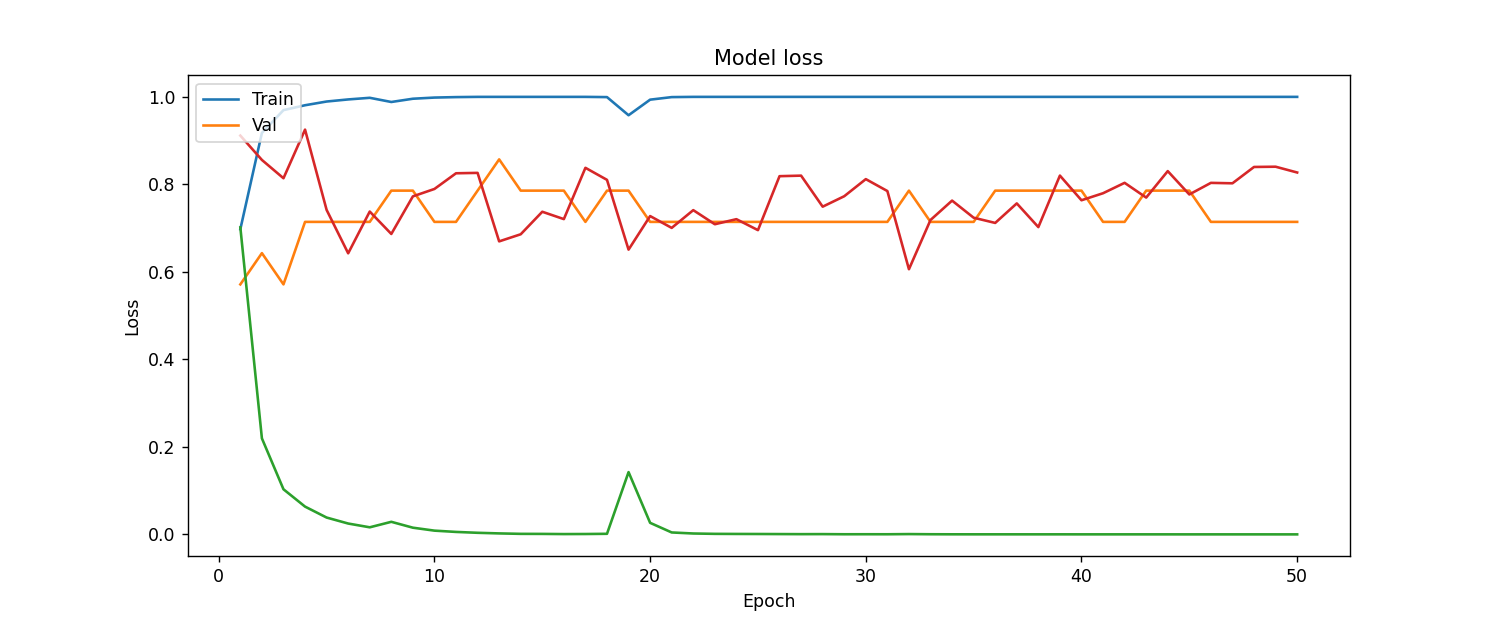

In [287]:
plt.figure()
plot_learningCurve(history, epo)

In [288]:
y_pred = model.predict_classes(X_test)
print(X_test.shape)
y_pred

(14, 104, 3)


array([2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 3, 1], dtype=int64)

(377,) (14,)
14/14 [==============================] - 0s 641us/sample - loss: 0.8272 - accuracy: 0.7143
test loss, test acc: [0.8271522521972656, 0.71428573]


<IPython.core.display.Javascript object>


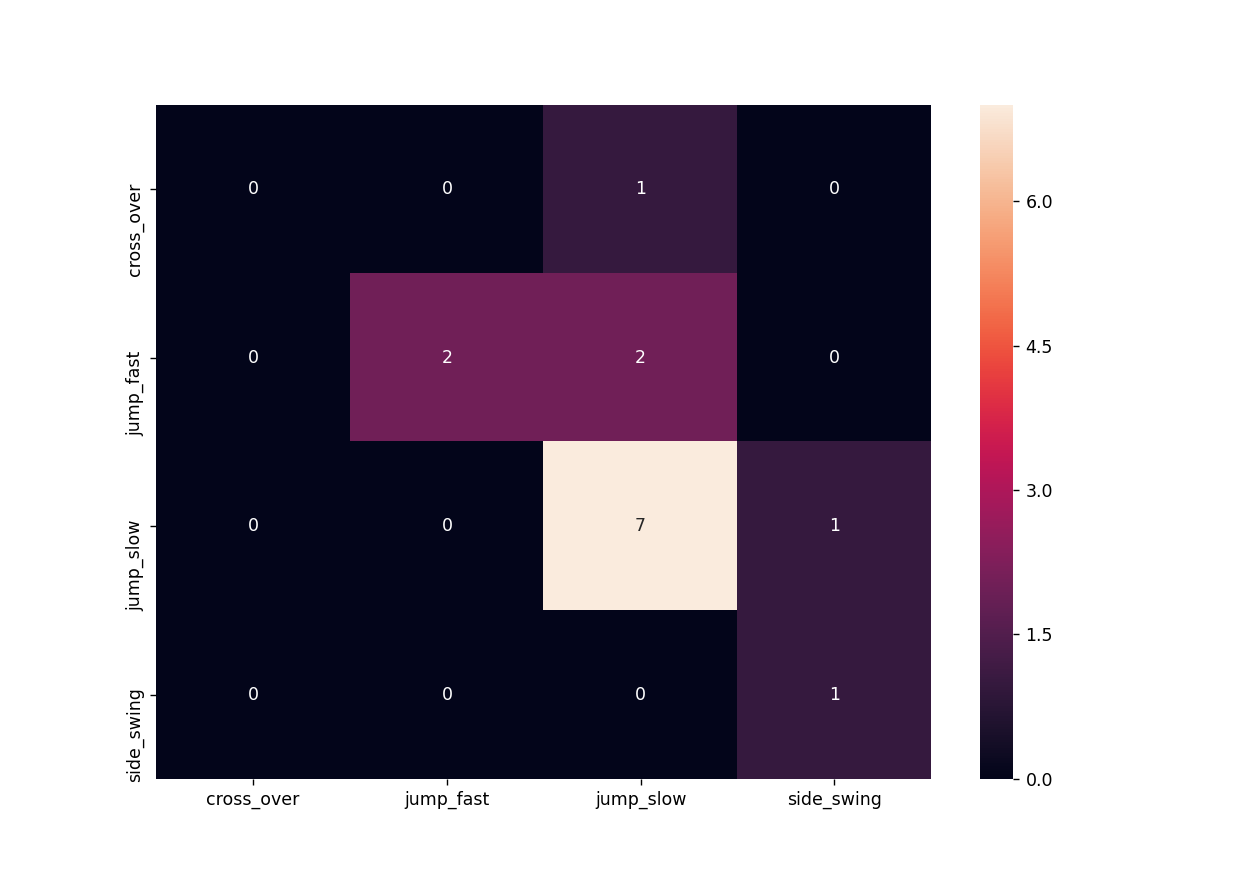

[0.8271522521972656, 0.71428573]


In [289]:
print(y_test_1.shape, y_pred.shape)
mat = confusion_matrix(y_labels, y_pred)
results = model.evaluate(X_test, y_test)
print('test loss, test acc:', results)
heatmap(mat, label)
print(results)

test loss, test acc: [0.384590016624142, 0.867052]


<IPython.core.display.Javascript object>


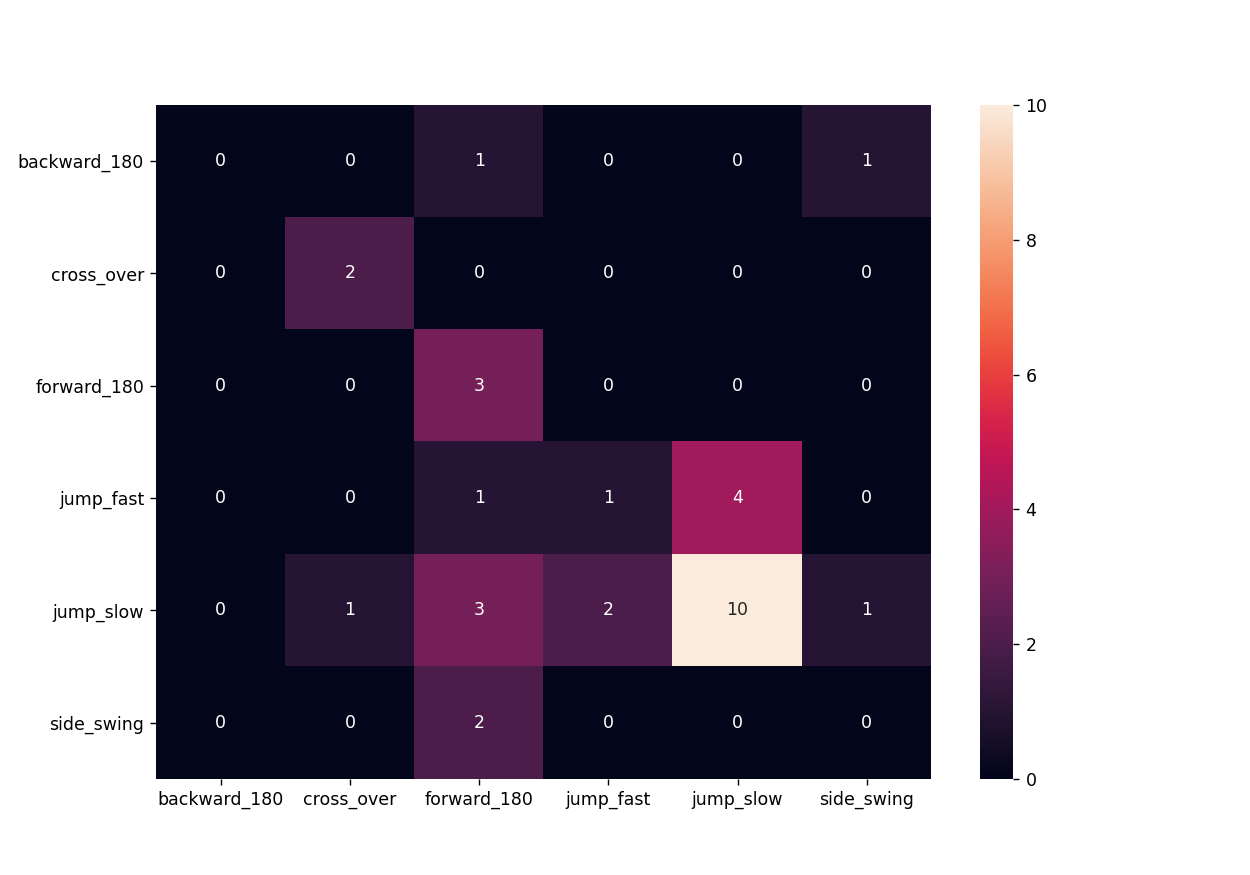

[0.384590016624142, 0.867052]


In [114]:
# volledige dataset
y = np.asarray(pd.get_dummies(Y), dtype = np.int8)
y_pred = model.predict_classes(val_data)
mat = confusion_matrix(val_labels, y_pred)
#results = model.evaluate(X, y)
print('test loss, test acc:', results)
heatmap(mat, label)
print(results)

## save model

In [38]:
model.save('rope_skipping_simple_cnn') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: rope_skipping_simple_cnn\assets


In [39]:
converter = tf.lite.TFLiteConverter.from_saved_model("rope_skipping_simple_cnn")
tflite_model = converter.convert()
open("converted_model2.tflite", "wb").write(tflite_model)

672848